In [0]:
! nvidia-smi

Wed May 20 08:20:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import pkgutil
import importlib
import os
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import seaborn as sns
import io
import skimage
from skimage.transform import resize
from itertools import groupby
from tqdm.auto import tqdm
from pathlib import Path
from time import time
from datetime import datetime 
import gc
sns.set()
from zipfile import ZipFile
import zipfile

# install "apex" model for mixed precision training if required.. this is needed for LRFinder
if pkgutil.find_loader("apex") is None:
   print("****apex module does not exist..hence installing*****")
   !pip install -U git+https://www.github.com/NVIDIA/apex --no-cache-dir

import albumentations
print(albumentations.__version__) # check version

# This is to install and use albumentations latest package v0.4.5
album_version_needed = "0.4.5"
if albumentations.__version__ != album_version_needed:
  !pip install albumentations==0.4.5   # 0.4.5 is the latest albumentation version
print('Pytorch version:', torch.__version__)

!pip install kornia
from kornia.losses import SSIM

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


****apex module does not exist..hence installing*****
  Cloning https://www.github.com/NVIDIA/apex to /tmp/pip-req-build-o_s9c_qa
  Running command git clone -q https://www.github.com/NVIDIA/apex /tmp/pip-req-build-o_s9c_qa
  Running command git submodule update --init --recursive -q
  Created wheel for apex: filename=apex-0.1-cp36-none-any.whl size=177467 sha256=2e54a3ab5b1815f970c01c2f61a9484f6f62061f0e916571461f520ded3c1ebb
  Stored in directory: /tmp/pip-ephem-wheel-cache-cd1a1p2e/wheels/08/3e/36/a75a9914e497fe42598f9dbe67496b2b300a8851f4d396a285
Successfully built apex
0.1.12
     |████████████████████████████████| 122kB 3.5MB/s 
     |████████████████████████████████| 634kB 38.6MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=a3e324c040227e0d56b08d6c7586fc384190fb4caf883d62a6b12514d520e6d6
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug:

Pytorch version: 1.5.0+cu101
     |████████████████████████████████| 163kB 3.5MB/s 


In [0]:
os.mkdir('/content/sample_data/FG_BG')
os.mkdir('/content/sample_data/Mask')
os.mkdir('/content/sample_data/Depth')

FG_BG_zip =  ZipFile("/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_400K.zip", 'r')
Mask_zip  = ZipFile("/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Mask_400K.zip", 'r')
Depth_zip = ZipFile("/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Depth_400K.zip", 'r')
all_files_FG_BG = [info.filename for info in FG_BG_zip.infolist() if not info.is_dir()]
all_files_Mask  = [info.filename for info in Mask_zip.infolist() if not info.is_dir()]
all_files_Depth = [info.filename for info in Depth_zip.infolist() if not info.is_dir()]
print(len(all_files_FG_BG))
print(len(all_files_Mask))
print(len(all_files_Depth))

path_fg_bg  = '/content/sample_data/FG_BG/'
path_mask   = '/content/sample_data/Mask/' 
path_depth  = '/content/sample_data/Depth/'

t1 = time()
k = 0
for img_file in all_files_FG_BG[0:20000]:
    if img_file.endswith('jpg'):
        imgdata = FG_BG_zip.read(img_file)
        img = Image.open(io.BytesIO(imgdata))
        file_name = img_file.split('/')[-1].split('.')[0] + '.jpg'
        img.save(f'{path_fg_bg}{file_name}')
        k += 1
print('FG_BG Written:',k) 

k = 0
for img_file in all_files_Mask[0:]:
    if img_file.endswith('jpg'):
        imgdata = Mask_zip.read(img_file)
        img = Image.open(io.BytesIO(imgdata))
        file_name = img_file.split('/')[-1].split('.')[0] + '.jpg'
        img.save(f'{path_mask}{file_name}')
        k += 1
print('Masks Written:',k) 

k = 0
for img_file in all_files_Depth[0:]:
    if img_file.endswith('jpg'):
        imgdata = Depth_zip.read(img_file)
        img = Image.open(io.BytesIO(imgdata))
        file_name = img_file.split('/')[-1].split('.')[0] + '.jpg'
        img.save(f'{path_depth}{file_name}')
        k += 1
print('Depth Written:',k) 

!cp -r '/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/BG_and_Its_Flip' '/content/sample_data/'
!cp '/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Filename_withflip_Logs.txt' '/content/sample_data/'

t2 = time()
print(f'Copy took {(t2-t1)/60:.5f} minutes')

400000
400000
400000
FG_BG Written: 20000
Masks Written: 400000
Depth Written: 400000
Copy took 15.60730 minutes


In [0]:
log_fg_bg = open('/content/sample_data/FG_BG_Filename_withflip_Logs.txt',"r")
content_list = log_fg_bg.readlines()
print('No: of records in log_fg_bg:',len(content_list))
print(content_list[0])
log_fg_bg.close()

data_root = Path('/content/sample_data')
f1, f2, f3, f4 = data_root/'FG_BG', data_root/'BG_and_Its_Flip', data_root/'Mask', data_root/'Depth'

No: of records in log_fg_bg: 400000
Img_fg_bg_1.jpg,Img21.jpg,Image41.png,(192, 192, 108, 156, 51, 3, 159, 3, 51, 159, 159, 159)



In [0]:
print(len(list(f1.iterdir())))
print(len(list(f2.iterdir())))
print(len(list(f3.iterdir())))
print(len(list(f4.iterdir())))

20000
210
400000
400000


In [0]:
bs   = 25
rows = 5
size = 192
prnt = 100
drpout = 0.0

In [0]:
gt_transform = transforms.Compose([transforms.Resize((192,192)),
                                      transforms.ToTensor(),])

In [0]:
bg_transform = transforms.Compose([#transforms.Resize((256,256)),
                                       transforms.ColorJitter(brightness =0.05,contrast=0.05,saturation=0.05,hue=0.05),
                                       transforms.ToTensor(),
                                       ])

In [0]:
fg_bg_transform = transforms.Compose([#transforms.Resize((256,256)),
                                       transforms.ColorJitter(brightness =0.05,contrast=0.05,saturation=0.05,hue=0.05),
                                       transforms.ToTensor(),
                                       ])

In [0]:
class MasterDataset(Dataset):
  def __init__(self,data_root,content_list, do_transform=True):
    self.f1_files     = list(f1.glob('*.jpg'))
    self.content_list = content_list
    self.do_transform    = do_transform

  def __len__(self):
    return len(self.f1_files)  

  def __getitem__(self,index):
    fg_bg_name   = self.f1_files[index].stem
    fg_bg_idx    = fg_bg_name.split('_')[-1]
    bg_name = '/content/sample_data/BG_and_Its_Flip/' + self.content_list[int(fg_bg_idx)-1].split(',')[1]
    mask_name    = '/content/sample_data/Mask/' + 'Img_fg_bg_mask' + str(fg_bg_idx) + '.jpg'
    depth_name   = '/content/sample_data/Depth/' + 'Img_fg_bg_' + str(fg_bg_idx) + '_depth.jpg'
    f1_image = Image.open(self.f1_files[index])  
    f2_image = Image.open(f'{bg_name}')
    f3_image = Image.open(f'{mask_name}')
    f4_image = Image.open(f'{depth_name}')

    if self.do_transform:
      f1_image = bg_transform(f1_image)
      f2_image = fg_bg_transform(f2_image)
      f3_image = (gt_transform(f3_image) > 0.8).float()
      f4_image = gt_transform(f4_image)

    return {'f1':f1_image, 'f2':f2_image, 'f3':f3_image, 'f4':f4_image}

In [0]:
train_ds = MasterDataset(data_root, content_list)

In [0]:
[(k, v.shape) for k, v in train_ds[0].items() if k != 'index']

[('f1', torch.Size([3, 192, 192])),
 ('f2', torch.Size([3, 192, 192])),
 ('f3', torch.Size([1, 192, 192])),
 ('f4', torch.Size([1, 192, 192]))]

In [0]:
train_dl = DataLoader(train_ds, batch_size = bs, shuffle = True, pin_memory = True)

In [0]:
sample = next(iter(train_dl))
type(sample)

dict

In [0]:
[(k, v.shape) for k, v in sample.items()]

[('f1', torch.Size([25, 3, 192, 192])),
 ('f2', torch.Size([25, 3, 192, 192])),
 ('f3', torch.Size([25, 1, 192, 192])),
 ('f4', torch.Size([25, 1, 192, 192]))]

In [0]:
imgs = sample['f4']

In [0]:
def show(tensors, figsize= (10,10), *args, **kwargs):
  grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)  
  grid_image  = grid_tensor.permute(1, 2, 0)
  plt.figure(figsize = figsize)
  plt.imshow(grid_image)
  plt.xticks([])  
  plt.yticks([])
  plt.show()

In [0]:
def show_pred(tensors, *args, **kwargs):
  tensors = (tensors * std[None, : , None, None]) + mean[None, :, None, None]
  show(tensors, *args, **kwargs)

In [0]:
def draw_and_save(tensors, name, figsize=(20,20), *args, **kwargs):
  try:
    tensors = tensors.detach().cpu()
  except:
    pass
  grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)
  grid_image  = grid_tensor.permute(1, 2, 0)
  plt.figure(figsize = figsize)
  plt.imshow(grid_image)
  plt.xticks([])  
  plt.yticks([])

  plt.savefig(name, bbox_inches='tight')
  plt.show()

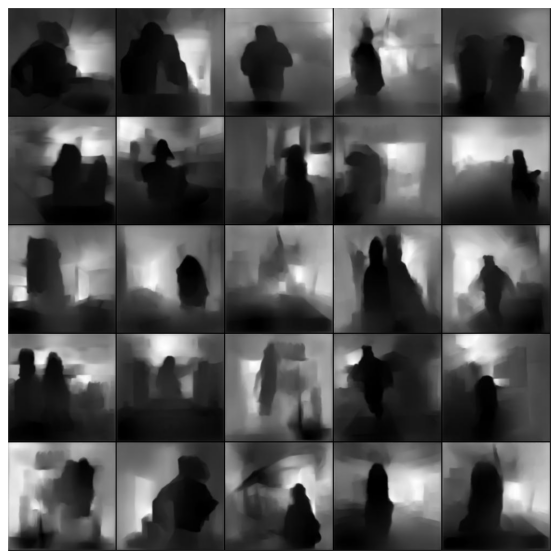

In [0]:
show(imgs, nrow=rows)

In [0]:
class DownResNet(nn.Module):
  def __init__(self,inchannels,outchannels):
    super(DownResNet, self).__init__()
    
    #print('DR-Enter')
    self.conv1  = nn.Conv2d(inchannels, outchannels, kernel_size=3, stride=2, padding=1, bias=False)
    #print('DR-After-conv1')
    self.conv12 = nn.Conv2d(outchannels, outchannels, kernel_size=1, stride=1, padding=0, bias=False)
    #print('DR-After-conv12')
    self.bn1 = nn.BatchNorm2d(outchannels)
    self.relu = nn.ReLU(inplace=False)

    self.conv2  = nn.Conv2d(outchannels, outchannels, kernel_size=3, stride=1, padding=1, bias=False)
    #print('DR-After-conv2')
    self.conv22 = nn.Conv2d(outchannels, outchannels, kernel_size=1, stride=1, padding=0, bias=False)
    #print('DR-After-conv22')
    self.bn2 = nn.BatchNorm2d(outchannels)

    self.conv1x1down = nn.Conv2d(inchannels, outchannels,kernel_size=1, stride=2, padding=0, bias=False)
    #print('DR-After-conv1x1down')

  def forward(self,x):
    print('Start DR')
    identity = self.conv1x1down(x)
    print('identity = self.conv1x1down(x)',identity.shape)
    out = self.conv1(x)
    print('out = self.conv1(x)',out.shape)
    out = self.conv12(out)
    print('out = self.conv12(out)',out.shape)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    print('out = self.conv2(out)',out.shape)
    out = self.conv22(out)
    print('out = self.conv22(out)',out.shape)
    out = self.bn2(out)

    out += identity
    print('out += identity',out.shape)
    out = self.relu(out)

    return out 

In [0]:
class UpResNet(nn.Module):
  def __init__(self, inchannels, outchannels):
    super(UpResNet, self).__init__()

    #print('UR-Enter')   
    self.conv1 = nn.Conv2d(outchannels, outchannels, kernel_size=3, stride=1, padding=1, bias=False)
    #print('UR-After-conv1')
    self.conv12 = nn.Conv2d(outchannels, outchannels, kernel_size=1, stride=1, padding=0, bias=False)
    #print('UR-After-conv12')
    self.bn1 = nn.BatchNorm2d(outchannels)
    self.relu = nn.ReLU(inplace = False)

    self.conv2 = nn.Conv2d(outchannels, outchannels, kernel_size=3, stride=1, padding=1, bias=False)
    #print('UR-After-conv2')
    self.conv22 = nn.Conv2d(outchannels, outchannels, kernel_size=1, stride=1, padding=0, bias=False)
    #print('UR-After-conv22')
    self.bn2 = nn.BatchNorm2d(outchannels)

    self.conv1x1down = nn.ConvTranspose2d(inchannels, outchannels, kernel_size=3, stride=1, padding=1, bias=False)
    #print('UR-After-conv1x1down')

  def forward(self, x):
    print('Start UR')
    identity = self.conv1x1down(x)
    print('identity = self.conv1x1down(x)',identity.shape)
    out = self.conv1(identity)
    print('out = self.conv1(identity)',out.shape)
    out = self.conv12(out)
    print('out = self.conv12(out)',out.shape)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    print('out = self.conv2(out)',out.shape)
    out = self.conv22(out)
    print('out = self.conv22(out)',out.shape)
    out = self.bn2(out)

  # out += x

    out = self.relu(out)  
    return out

In [0]:
class BGDPTH(nn.Module):
  def __init__(self):
    super(BGDPTH, self).__init__()

    self.convFirst = nn.Sequential(nn.Conv2d(6,64,kernel_size=7,stride=2,padding=3,bias=False),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(inplace=False))
    
    self.maxpool = nn.MaxPool2d(3, stride = 2, padding =1)

    self.rb1 = DownResNet(64,128)
    self.rb2 = DownResNet(128,256)
    self.rb3 = DownResNet(256,512)

    self.rb4 = UpResNet(512, 256)
    self.rb5 = UpResNet(256, 128)
    self.rb6 = UpResNet(128, 64)

    self.rb7 = UpResNet(64,64)

    self.rb8 = UpResNet(64,32)

    self.convLast = nn.Sequential(nn.Conv2d(32, 1, kernel_size=1, stride=1, padding=0, bias=False),)

    self.rb4D = UpResNet(512, 256)
    self.rb5D = UpResNet(256, 128) 
    self.rb6D = UpResNet(128, 64)

    self.rb7D = UpResNet(64, 64)

    self.rb8D = UpResNet(64, 32)

    self.convLastD = nn.Sequential(nn.Conv2d(32, 1, kernel_size=1, stride=1, padding=0, bias=False),)

  def forward(self, y):
    #f11 = sample['f1']
    #f22 = sample['f2']
    print('Start BGDPTH')
    f11  = y
    f22  = y
    f   = torch.cat([f11,f22], dim=1)
    print('f   = torch.cat([f11,f22], dim=1)',f.shape)

    out0 = self.convFirst(f)
    print('out0 = self.convFirst(f)',out0.shape)
    out1 = self.maxpool(out0)
    print('out1 = self.maxpool(out0)',out1.shape)
    out2 = self.rb1(out1)
    print('out2 = self.rb1(out1)',out2.shape)
    out3 = self.rb2(out2)
    print('out3 = self.rb2(out2)',out3.shape)
    out4 = self.rb3(out3)
    print('out4 = self.rb3(out3)',out4.shape)

    out4 = nn.functional.interpolate(out4, scale_factor=2, mode='bilinear')
    print("out4 = nn.functional.interpolate(out4, scale_factor=2, mode='bilinear')",out4.shape)

    out5 = self.rb4(out4)
    print('out5 = self.rb4(out4)',out5.shape)
    out5 += out3
    print('out5 += out3',out5.shape)
    out5 = nn.functional.interpolate(out5, scale_factor=2, mode='bilinear')
    print("out5 = nn.functional.interpolate(out5, scale_factor=2, mode='bilinear')",out5.shape)
    out6 = self.rb5(out5)
    print('out6 = self.rb5(out5)',out6.shape)
    out6 += out2 
    print('out6 += out2',out6.shape)
    out6 = nn.functional.interpolate(out6, scale_factor=2, mode='bilinear')
    print("out6 = nn.functional.interpolate(out6, scale_factor=2, mode='bilinear')",out6.shape)
    out7 = self.rb6(out6)
    print('out7 = self.rb6(out6)',out7.shape)
    out7 += out1
    print('out7 += out1',out7.shape)
    out7 = nn.functional.interpolate(out7, scale_factor=2, mode='bilinear')
    print("out7 = nn.functional.interpolate(out7, scale_factor=2, mode='bilinear')",out7.shape)
    out8 = self.rb7(out7)
    print('out8 = self.rb7(out7)',out8.shape)
    out8 += out0
    print('out8 += out0',out8.shape)

    out9 = nn.functional.interpolate(out8, scale_factor=2, mode='bilinear')
    print("out9 = nn.functional.interpolate(out8, scale_factor=2, mode='bilinear')",out9.shape)
    out9 = self.rb8(out9)
    print('out9 = self.rb8(out9)',out9.shape)

    outB = self.convLast(out9)
    print('outB = self.convLast(out9)',outB.shape)

    out5D = self.rb4D(out4)
    print('out5D = self.rb4D(out4)',out5D.shape)
    out5D += out3
    print('out5D += out3',out5D.shape)
    out5D = nn.functional.interpolate(out5D, scale_factor=2, mode='bilinear')
    print("out5D = nn.functional.interpolate(out5D, scale_factor=2, mode='bilinear')",out5D.shape)
    out6D = self.rb5D(out5D)
    print('out6D = self.rb5D(out5D)',out6D.shape)
    out6D += out2
    print('out6D += out2',out6D.shape)
    out6D = nn.functional.interpolate(out6D, scale_factor=2, mode='bilinear')
    print("out6D = nn.functional.interpolate(out6D, scale_factor=2, mode='bilinear')",out6D.shape)
    out7D = self.rb6D(out6D)
    print('out7D = self.rb6D(out6D)',out7D.shape)
    out7D += out1
    print('out7D += out1',out7D.shape)
    out7D = nn.functional.interpolate(out7D, scale_factor=2, mode='bilinear')
    print("out7D = nn.functional.interpolate(out7D, scale_factor=2, mode='bilinear')",out7D.shape)
    out8D = self.rb7D(out7D)
    print('out8D = self.rb7D(out7D)',out8D.shape)
    out8D += out0
    print('out8D += out0',out8D.shape)

    out9D = nn.functional.interpolate(out8D, scale_factor=2, mode='bilinear')
    print("out9D = nn.functional.interpolate(out8D, scale_factor=2, mode='bilinear')",out9D.shape)
    out9D = self.rb8D(out9D)
    print('out9D = self.rb8D(out9D)',out9D.shape)

    outD  = self.convLastD(out9D)
    print('outD  = self.convLastD(out9D)',outD.shape)

    return outB, outD

In [0]:
def weights_init(ms):
  for m in ms.modules():
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
      m.weight.data = m.init.kaiming_normal_(m.weight.data, mode='fan_out',nonlinearity='relu')
    elif classname.find('ConvTranspose2d') != -1:
      m.weight.data = m.init.kaiming_normal_(m.weight.data, mode='fan_out',nonlinearity='relu')
    elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight, 1)
      nn.init.constant_(m.bias,0)

In [0]:
#kernel_size = 3
#criterion = SSIM(kernel_size, reduction = 'mean)
criterion = nn.BCEWithLogitsLoss()

In [0]:
model    = BGDPTH()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)

BGDPTH(
  (convFirst): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (rb1): DownResNet(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (conv12): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv22): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1x1down): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
  )
  (rb2): DownResNet(
    (conv1

In [0]:
from torchsummary import summary
summary(model, input_size=(3,192,192))

Start BGDPTH
f   = torch.cat([f11,f22], dim=1) torch.Size([2, 6, 192, 192])
out0 = self.convFirst(f) torch.Size([2, 64, 96, 96])
out1 = self.maxpool(out0) torch.Size([2, 64, 48, 48])
Start DR
identity = self.conv1x1down(x) torch.Size([2, 128, 24, 24])
out = self.conv1(x) torch.Size([2, 128, 24, 24])
out = self.conv12(out) torch.Size([2, 128, 24, 24])
out = self.conv2(out) torch.Size([2, 128, 24, 24])
out = self.conv22(out) torch.Size([2, 128, 24, 24])
out += identity torch.Size([2, 128, 24, 24])
out2 = self.rb1(out1) torch.Size([2, 128, 24, 24])
Start DR
identity = self.conv1x1down(x) torch.Size([2, 256, 12, 12])
out = self.conv1(x) torch.Size([2, 256, 12, 12])
out = self.conv12(out) torch.Size([2, 256, 12, 12])
out = self.conv2(out) torch.Size([2, 256, 12, 12])
out = self.conv22(out) torch.Size([2, 256, 12, 12])
out += identity torch.Size([2, 256, 12, 12])
out3 = self.rb2(out2) torch.Size([2, 256, 12, 12])
Start DR
identity = self.conv1x1down(x) torch.Size([2, 512, 6, 6])
out = self.c

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:
optim = torch.optim.SGD(model.parameters(),lr=0.001, momentum = 0.9, weight_decay = 1e-5)

In [0]:
def train(model, criterion, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  for batch_idx, data in enumerate(pbar):
    data['f1'] = data['f1'].to(device)
    data['f2'] = data['f2'].to(device)
    data['f3'] = data['f3'].to(device)
    data['f4'] = data['f4'].to(device)    

    optimizer.zero_grad()
    output = model(data)

 # breakpoint()

    loss1 = criterion(output[0], data['f3'])
    loss2 = criterion(output[1], data['f4'])
    loss  = 2*loss1 + loss2

    pbar.set_description(desc = f'loss={loss.item()} l1={loss1.item()} l2={loss2.item()}')   
    loss.backward()
    optimizer.step()

    if batch_idx % prnt == 0:
      #show_pred(output.detach().cpu(), nrow =2) # nrow = sqrt-bs
      draw_and_save(output[0].detach().cpu(), f'/content/sample_data/plots/{epoch}_{batch_idx}_BR_{loss1.item()}.jpg')
      draw_and_save(output[1].detach().cpu(), f'/content/sample_data/plots/{epoch}_{batch_idx}_DR_{loss2.item()}.jpg')
      draw_and_save(data['f3'].detach().cpu(), f'/content/sample_data/plots/{epoch}_{batch_idx}_BG_{loss.item()}.jpg')
      draw_and_save(data['f4'].detach().cpu(), f'/content/sample_data/plots/{epoch}_{batch_idx}_DG_{loss.item()}.jpg')
      draw_and_save(data['f2'].detach().cpu(), f'/content/sample_data/plots/{epoch}_{batch_idx}_IN_{loss.item()}.jpg')

      #show(data['f2'].detach().cpu(), nrow=5)

    #if batch_idx % 650 == 0:
    #  torch.save(model.state_dict(),PATH/f'{epoch}_{batch_idx}_{loss.item()}.pth')

In [0]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optim, step_size=2, gamma=0.1)

In [0]:
for epoch in range(1,2):
  train(model, criterion,model.device, train_dl, optim, epoch)
  #test(model, device, test_loader)
  scheduler.step()